In [1]:
#Change directory to data location
import os
path = 'E:\Daily Reanalisis ERA 5 v2'
os.chdir(path)

In [2]:
import warnings
warnings.simplefilter('ignore') #ignores simple warning

In [3]:
#Import package
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import matplotlib.ticker as tk
import matplotlib.patches as mpatches
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [4]:
#Read time-event excel data
censevt=pd.read_excel('calculation_output\CENS Event 3 days Running Mean.xlsx')
censevt=censevt.set_index('time_cens')

In [5]:
#Date event CENS CS no CS (1-->CS, 0-->no CS)
n_cens = 2
evt_cens_cs = []
for i in range(n_cens):
    evt_cens = censevt[censevt['cs event'] == i].index
    print("Number of CENS {i} = {n} dari {x}".format(i=i, n=len(evt_cens), x=len(censevt)))
    print("Number of CENS {i} = {n}%".format(i=i, n=(len(evt_cens)*100/len(censevt.index))))
    evt_cens_cs.append(evt_cens.values)

Number of CENS 0 = 48 dari 117
Number of CENS 0 = 41.02564102564103%
Number of CENS 1 = 69 dari 117
Number of CENS 1 = 58.97435897435897%


In [6]:
datav925 = xr.open_mfdataset('v925\*.nc',combine = 'by_coords')
datat2m = xr.open_mfdataset('t2m\*.nc',combine = 'by_coords')
datamslp = xr.open_mfdataset('mslp\*.nc',combine = 'by_coords')

In [7]:
lat=datav925['lat'].values
lon=datav925['lon'].values

In [8]:
v925=datav925['v'].rolling(time=3, center=True).mean().sel(time=datav925.time.dt.season=="DJF").sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
t2m=datat2m['t2m'].rolling(time=3, center=True).mean().sel(time=datat2m.time.dt.season=="DJF").sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
mslp=datamslp['msl'].rolling(time=3, center=True).mean().sel(time=datamslp.time.dt.season=="DJF").sel(time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))/100

In [9]:
v925nm=datav925['v'].rolling(time=3, center=True).mean().sel(time=datav925.time.dt.month.isin([1, 2, 3, 11, 12])).sel(time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000'))
t2mnm=datat2m['t2m'].rolling(time=3, center=True).mean().sel(time=datat2m.time.dt.month.isin([1, 2, 3, 11, 12])).sel(time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000'))
mslpnm=datamslp['msl'].rolling(time=3, center=True).mean().sel(time=datamslp.time.dt.month.isin([1, 2, 3, 11, 12])).sel(time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000'))/100

In [10]:
climv925 = v925.mean('time')
anv925djf = v925nm- climv925
climt2m = t2m.mean('time')
ant2mdjf = t2mnm - climt2m
climslp = mslp.mean('time')
anslpdjf = mslpnm - climslp

In [11]:
v925djfclim= xr.Dataset(
     {"v": (("time","lat","lon"), anv925djf.values)},
    coords={
    "time": anv925djf['time'],    
    "lat": lat,
    "lon": lon},
    )

In [12]:
slpdjfclim= xr.Dataset(
     {"slp": (("time","lat","lon"), anslpdjf.values)},
    coords={
    "time": anslpdjf['time'],    
    "lat": lat,
    "lon": lon},
    )

In [13]:
t2mdjfclim= xr.Dataset(
     {"t2m": (("time","lat","lon"), ant2mdjf.values)},
    coords={
    "time": ant2mdjf['time'],    
    "lat": lat,
    "lon": lon},
    )

In [14]:
#Change CS and no-CS array for plot
evt_cens_cs=[evt_cens_cs[1], evt_cens_cs[0]]

In [15]:
def bootstrap_3dxr(data, sample_size, n_samples, percentile):
    
    # create a list for sample means
    sample_means = []
    
    # loop n_samples times
    for i in tqdm(range(n_samples)):
        t=data.time
        trand=np.random.choice(t, size=sample_size, replace=False)
        datarandmean=data.sel(time=np.in1d(data.time,trand)).mean(dim='time')
        sample_means.append(datarandmean.values)
        
    low=np.percentile(sample_means,percentile/2, axis=0)
    high=np.percentile(sample_means,100-percentile/2, axis=0)
    
    return low, high #2D low and high threshold

In [16]:
def datasethov(data, timecens):
    lat=data['lat']
    lon=data['lon']
    ancens=np.empty([len(timecens), 10, len(lat), len(lon)], dtype=np.float32)
    for i in tqdm(range(len(timecens))):
        for j,k in zip(range(10), np.arange(-6,4,1)):
            ancens[i,j]=data.sel(time=np.in1d(data.time, timecens[i]+np.timedelta64(k,'D')))
            
    andata=xr.Dataset(
     {"var": (("time", "z", "lat", "lon"), ancens) },
    coords={
    "time": timecens,
    "z" :np.arange(-6,4,1),
    "lat": lat,
    "lon": lon,
    },
    )
    return andata

In [17]:
pvaluemslp=np.empty([2, 10, len(lat)])
data=slpdjfclim['slp'].sel(time=slpdjfclim.time.dt.season=="DJF").sel(lon=slice(100,135)).mean(dim='lon')
for c in range(2):
    low, high = bootstrap_3dxr(data, len(evt_cens_cs[c]), 1000, 1)
    low = np.tile(low, (10, 1))
    high = np.tile(high, (10, 1))
    for d, n in zip([-5,-3,-1,0,1], range(5)):
        compdata=datasethov(slpdjfclim['slp'], np.array(censevt.index)).sel(lon=slice(100,135)).mean(dim='lon')
        compositemean=compdata['var'].sel(time=np.in1d(compdata.time, evt_cens_cs[c])).mean(dim='time')
        pvaluemslp[c]=np.logical_or(compositemean<low, compositemean>high).values
pvaluemslptf=pvaluemslp

100%|███████████████████████████████████████████████████████████████████████████████| 117/117 [00:01<00:00, 112.99it/s]


In [18]:
pvaluev925=np.empty([2, 10, len(lat)])
data=v925djfclim['v'].sel(time=v925djfclim.time.dt.season=="DJF").sel(lon=slice(100,135)).mean(dim='lon')
for c in range(2):
    low, high = bootstrap_3dxr(data, len(evt_cens_cs[c]), 1000, 1)
    low = np.tile(low, (10, 1))
    high = np.tile(high, (10, 1))
    for d, n in zip([-5,-3,-1,0,1], range(5)):
        compdata=datasethov(v925djfclim['v'], np.array(censevt.index)).sel(lon=slice(100,135)).mean(dim='lon')
        compositemean=compdata['var'].sel(time=np.in1d(compdata.time, evt_cens_cs[c])).mean(dim='time')
        pvaluev925[c]=np.logical_or(compositemean<low, compositemean>high).values
pvaluev925tf=pvaluev925

100%|███████████████████████████████████████████████████████████████████████████████| 117/117 [00:01<00:00, 108.45it/s]


In [19]:
pvaluet2m=np.empty([2, 10, len(lat)])
data=t2mdjfclim['t2m'].sel(time=t2mdjfclim.time.dt.season=="DJF").sel(lon=slice(100,135)).mean(dim='lon')
for c in range(2):
    low, high = bootstrap_3dxr(data, len(evt_cens_cs[c]), 1000, 1)
    low = np.tile(low, (10, 1))
    high = np.tile(high, (10, 1))
    for d, n in zip([-5,-3,-1,0,1], range(5)):
        compdata=datasethov(t2mdjfclim['t2m'], np.array(censevt.index)).sel(lon=slice(100,135)).mean(dim='lon')
        compositemean=compdata['var'].sel(time=np.in1d(compdata.time, evt_cens_cs[c])).mean(dim='time')
        pvaluet2m[c]=np.logical_or(compositemean<low, compositemean>high).values
pvaluet2mtf=pvaluet2m

100%|███████████████████████████████████████████████████████████████████████████████| 117/117 [00:01<00:00, 107.95it/s]


In [20]:
#Color setting
coolwarm =cm.get_cmap('coolwarm', 100)
coolwarm =coolwarm(np.linspace(0,1,100))
white = np.array([255/256, 255/256, 255/256, 1])
cool =coolwarm[:50,:]
warm =coolwarm[50:,:]
newcolors = np.vstack((cool,white,warm))
newcmp = ListedColormap(newcolors, name='cww')

In [21]:
#Color setting
RdYlBu =cm.get_cmap('RdYlBu_r', 100)
RdYlBu =RdYlBu(np.linspace(0,1,100))
white = np.array([255/256, 255/256, 255/256, 1])
bu =cm.get_cmap('Blues_r', 100)(np.linspace(0,1,100))[30:,:]
rd =cm.get_cmap('Reds', 100)(np.linspace(0,1,100))[:70,:]
newcolors = np.vstack((bu,white,rd))
burd = ListedColormap(newcolors, name='burd')

100%|███████████████████████████████████████████████████████████████████████████████| 117/117 [00:01<00:00, 104.44it/s]


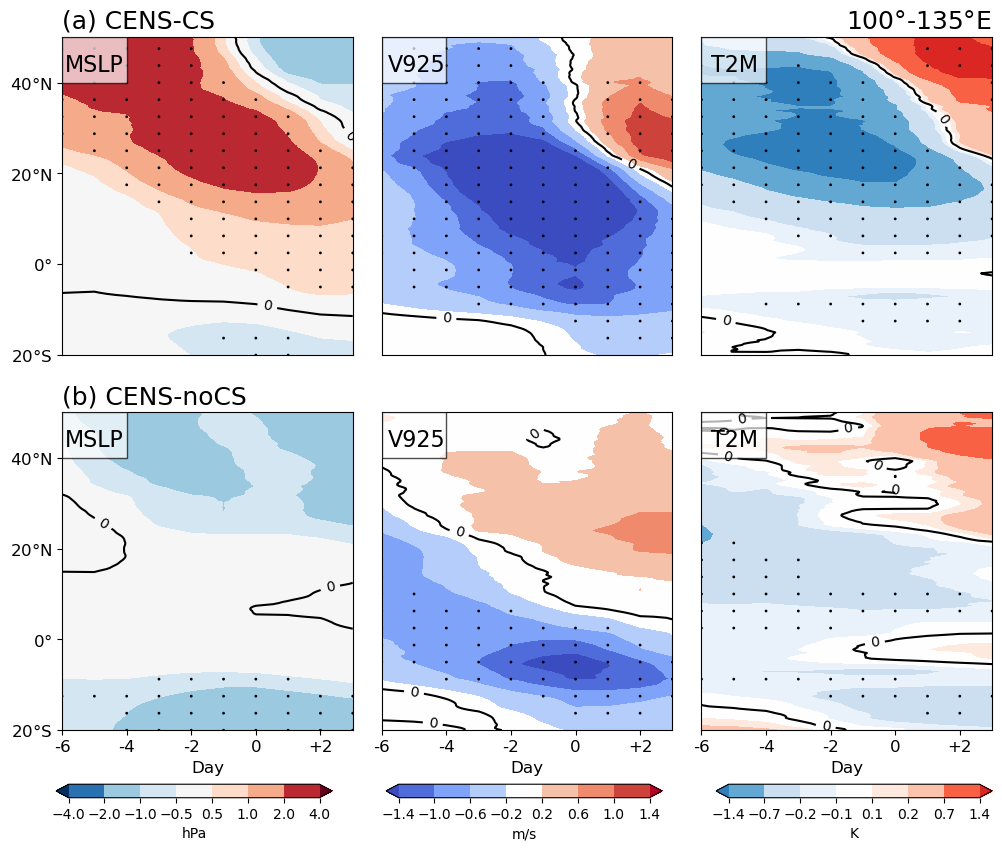

In [23]:
#Plot Hovmoller
fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(12,9))
for k in range(3):
    for i in range(2):
        if k==0:
            anslp=datasethov(slpdjfclim['slp'], np.array(censevt.index))['var']
            valueslp=anslp.sel(time=np.in1d(anslp.time, evt_cens_cs[i])).sel(lon=slice(100,135)).mean(dim='lon').mean(dim='time').transpose()
            plotvalslp=axs[i,k].contourf(anslp['z'], anslp['lat'], valueslp,
                                 cmap='RdBu_r',
                                 levels=[-4,-2,-1,-0.5,0.5,1,2,4], 
                                 extend='both')
            ctr=axs[i,k].contour(anslp['z'], anslp['lat'], valueslp,
                                 colors='k',
                                 levels=[0])
            axs[i,k].clabel(ctr, ctr.levels, inline=True, fontsize=10)
            skip=15
            x,y=np.meshgrid(np.arange(-6,3.5,1), lat[::skip])
            axs[i,k].scatter(x,y,np.transpose(pvaluemslptf[i][:,::skip])*1,color='k', linewidth=1)
            if i==0:
                axs[i,k].tick_params(bottom=False, labelbottom=False)
            axs[i,k].set_yticks(np.arange(-20,55,20))
            axs[i,k].set_yticklabels([r'$20\degree$'+'S',r'$0\degree$',r'$20\degree$'+'N',r'$40\degree$'+'N'], fontsize=12)
            axs[i,k].set_xticks(np.arange(-6,3.5,2))
            axs[i,k].set_xticklabels(['-6','-4', '-2', '0', '+2'], fontsize=12)
            if i==1:
                axs[i,k].set_xlabel('Day', fontsize=12)
            if i==0:
                axs[i,k].set_title('(a) CENS-CS', loc='left', fontsize=18)
            if i==1:
                axs[i,k].set_title('(b) CENS-noCS', loc='left', fontsize=18)
            
            longitude1, latitude1 = -6, 40
            longitude2, latitude2 = -4, 50
            axs[i,k].add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                        facecolor='white', edgecolor='k', linewidth=1, alpha=0.7, zorder=3))
            axs[i,k].text(-5.9,42.3,'MSLP',fontsize=16, c='k')
                
        if k==1:
            anv925=datasethov(v925djfclim['v'], np.array(censevt.index))['var']
            valuev925=anv925.sel(time=np.in1d(anv925.time, evt_cens_cs[i])).sel(lon=slice(100,135)).mean(dim='lon').mean(dim='time').transpose()
            plotvalv925=axs[i,k].contourf(anv925['z'], anv925['lat'], valuev925,
                                 cmap=newcmp,
                                 levels=np.arange(-1.4,1.5,0.4), 
                                 extend='both')
            ctr=axs[i,k].contour(anv925['z'], anv925['lat'], valuev925,
                                 colors='k',
                                 levels=[0])
            axs[i,k].clabel(ctr, ctr.levels, inline=True, fontsize=10)
            skip=15
            x,y=np.meshgrid(np.arange(-6,3.5,1), lat[::skip])
            axs[i,k].scatter(x,y,np.transpose(pvaluev925tf[i][:,::skip])*1,color='k', linewidth=1)
            axs[i,k].tick_params(left=False, labelleft=False)
            if i==0:
                axs[i,k].tick_params(bottom=False, labelbottom=False)
            axs[i,k].set_xticks(np.arange(-6,3.5,2))
            axs[i,k].set_xticklabels(['-6','-4', '-2', '0', '+2'], fontsize=12)
            if i==1:
                axs[k,i].set_xlabel('Day', fontsize=12)
            longitude1, latitude1 = -6, 40
            longitude2, latitude2 = -4, 50
            axs[i,k].add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                        facecolor='white', edgecolor='k', linewidth=1, alpha=0.7, zorder=3))
            axs[i,k].text(-5.8,42.3,'V925',fontsize=16, c='k')
        if k==2:
            ant2m=datasethov(t2mdjfclim['t2m'], np.array(censevt.index))['var']
            valuet2m=ant2m.sel(time=np.in1d(ant2m.time, evt_cens_cs[i])).sel(lon=slice(100,135)).mean(dim='lon').mean(dim='time').transpose()
            plotvalt2m=axs[i,k].contourf(ant2m['z'], ant2m['lat'], valuet2m,
                                 cmap=burd,
                                 levels=[-1.4,-0.7,-0.2,-0.1,0.1,0.2,0.7,1.4], 
                                 extend='both')
            ctr=axs[i,k].contour(ant2m['z'], ant2m['lat'], valuet2m,
                                 colors='k',
                                 levels=[0])
            axs[i,k].clabel(ctr, ctr.levels, inline=True, fontsize=10)
            skip=15
            x,y=np.meshgrid(np.arange(-6,3.5,1), lat[::skip])
            axs[i,k].scatter(x,y,np.transpose(pvaluet2mtf[i][:,::skip])*1,color='k', linewidth=1)
            axs[i,k].tick_params(left=False, labelleft=False)
            if i==0:
                axs[i,k].tick_params(bottom=False, labelbottom=False)
            axs[i,k].set_xticks(np.arange(-6,3.5,2))
            axs[i,k].set_xticklabels(['-6','-4', '-2', '0', '+2'], fontsize=12)
            if i==1:
                axs[i,k].set_xlabel('Day', fontsize=12)
            longitude1, latitude1 = -6, 40
            longitude2, latitude2 = -4, 50
            axs[i,k].add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                        facecolor='white', edgecolor='k', linewidth=1, alpha=0.7, zorder=3))
            axs[i,k].text(-5.7,42.3,'T2M',fontsize=16, c='k')
            if i==0:
                axs[i,k].set_title(r'$100\degree$'+'-'+r'$135\degree$'+'E', loc='right', fontsize=18)

cbar_slp = fig.add_axes([0.12, 0.035, 0.23, 0.015])
cbar_v = fig.add_axes([0.395, 0.035, 0.23, 0.015])
cbar_t = fig.add_axes([0.67, 0.035, 0.23, 0.015])
fig.subplots_adjust(wspace=0.1, hspace=0.18)
cbarslp = fig.colorbar(plotvalslp, cax=cbar_slp, label='hPa', orientation='horizontal')
cbarv = fig.colorbar(plotvalv925, cax=cbar_v, label='m/s', orientation='horizontal')
cbarv = fig.colorbar(plotvalt2m, cax=cbar_t, label='K', orientation='horizontal')
#plt.savefig('figure_output\Fig 4.pdf',  bbox_inches='tight')
plt.show()       